In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from numpy import linalg as LA
# from scipy import stats
# from sklearn import linear_model
# from sklearn.manifold import MDS
# from scipy.spatial import distance

import tensorflow.compat.v1 as tf
from tensorflow.python.ops import parallel_for as pfor
tf.disable_v2_behavior()

from pathlib import Path
import dotenv
import json
dotenv.load_dotenv()
p_code = Path(os.environ.get("HOME_DIR"))
p_data = Path(os.environ.get("DATA_DIR"))

net = 'stepnet'
PATH_YANGNET = os.path.join(p_code,net) 
sys.path.insert(0, PATH_YANGNET)

from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
import tools
from tools_lnd import make_D_use, same_stim_trial, make_h_combined, name_best_ckpt, plot_N, make_Jac_u_dot_delu, rule_set_names
from tools_lnd import make_h_and_Jac, gen_trials_from_model_dir, gen_X_from_model_dir_epoch, gen_X_from_model_dir

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# ##################################################################
# #fig save path
# ##################################################################
fig_name = 'suppfig9'
figpath = os.path.join(p_code,'figs',fig_name,fig_name+'ABC')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [4]:
# ##################################################################
# #Find right model dir
# ##################################################################
m = os.path.join(p_data,fig_name)

In [5]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']##################

rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
ruleset = 'all'
rule_trains = rules_dict[ruleset]
n_tasks = str(len(rule_trains))
rule_trains_str = '_'.join(rule_trains)
n_rnn = str(128)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = '1'
lr = -6
sigma_rec = 1/20
sigma_x = 2/20
w_rec_coeff  = 8/10

net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)
net_name2 = '_sig_rec'+str(sigma_rec)+'_sig_x'+str(sigma_x)+'_w_rec_coeff'+"{:.1f}".format(w_rec_coeff)+'_'+rule_trains_str

dir_specific_all = '_'.join((rnn_type,activation,w_init,str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name+net_name2,str(seed)))

model_dir_all = os.path.join(m,dir_specific_all)

In [6]:
# Ok jumping into the meat of it- This code generates a list of hidden state activity 
# and input Jacobians for the different tasks.

def get_var_across_stim(model_dir_all,trial_master,task_num):
    trial = same_stim_trial(trial_master,task_num)
    X,x = gen_X_from_model_dir(model_dir_all,trial)
    var = np.var(x,axis=1)
    return var

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
Instructions for updating:
Call initializer instance with the dtype argument instea

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.


2024-04-17 15:22:20.525725: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig9/LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig9/LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
IN

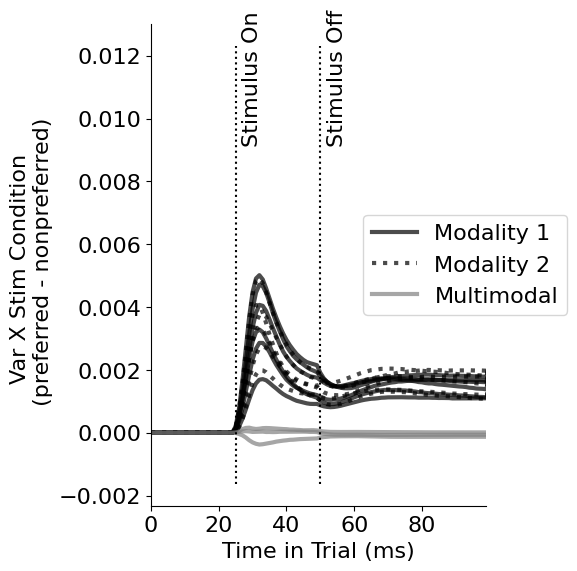

In [7]:
task_set = range(6,11)
# model_dir_all = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n_temp))
trial_master1 = gen_trials_from_model_dir(model_dir_all,'delaydm1',noise_on = False)
trial_master2 = gen_trials_from_model_dir(model_dir_all,'delaydm2',noise_on = False)
stim_start = trial_master1.epochs['stim1'][0]
stim_end = trial_master1.epochs['stim1'][1]
cmap=plt.get_cmap('coolwarm')
cl = [.1,.9,.3,.7,.5]
fig = plt.figure(figsize=(6, 6),tight_layout=True)
plt.rcParams.update({'font.size': 16})
ax = plt.subplot(1,1,1)
for seed in range(3):
    # model_dir_all = os.path.join(p,'data','rnn','multitask',net,'final1',ruleset,rnn_type,activation,
    #                              w_init,str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',
    #                              net_name+net_name2,str(seed))

    dir_specific_all = '_'.join((rnn_type,activation,w_init,str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name+net_name2,str(seed)))
    model_dir_all = os.path.join(m,dir_specific_all)

    for t in range(len(task_set)):
        task_num = task_set[t]
        var1 = get_var_across_stim(model_dir_all,trial_master1,task_num)
        var2 = get_var_across_stim(model_dir_all,trial_master2,task_num)
        var_diff = np.mean(var1,axis = 0) - np.mean(var2,axis = 0)
        
        if task_num==6:
            if seed==0:
                plt.plot(var_diff, label = 'Modality 1', color = 'k',linewidth = 3,alpha = .7)
            else:
                plt.plot(var_diff, color = 'k',linewidth = 3,alpha = .7)
                
        elif task_num==8:
            plt.plot(var_diff, color = 'k',linewidth = 3,alpha = .7)
            
        elif task_num==7:
            if seed==0:
                plt.plot(-var_diff, ':k', label = 'Modality 2',linewidth = 3,alpha = .7)
            else:
                plt.plot(-var_diff, ':k',linewidth = 3,alpha = .7)
        
        elif task_num==9:
            plt.plot(-var_diff, ':k',linewidth = 3,alpha = .7)
            
        elif task_num==10:
            
            if seed==0:
                plt.plot(var_diff, label = 'Multimodal', color = 'gray',linewidth = 3,alpha = .7)
            else:
                plt.plot(var_diff, color = 'gray',linewidth = 3,alpha = .7)
            
ymin, ymax = ax.get_ylim()        
plt.plot([stim_start,stim_start],[ymin,ymax],':k')
# plt.plot([stim_start,stim_start],[-.15,.15],':k')
plt.text(stim_start+2,3*ymax/4,'Stimulus On',rotation = 90)

plt.plot([stim_end,stim_end],[ymin,ymax],':k')
# plt.plot([stim_end,stim_end],[-.15,.15],':k')
plt.text(stim_end+2,3*ymax/4,'Stimulus Off',rotation = 90)
plt.ylabel('Var X Stim Condition \n (preferred - nonpreferred)')
plt.xlabel('Time in Trial (ms)')
# plt.xticks(range(0,80,20),range(0,80,20)*10)
plt.legend(loc='center left', bbox_to_anchor=[.6,.5])
plt.xlim((0,99))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(os.path.join(figpath,'vaxXstimCond.pdf'))
plt.show()

In [8]:
dir_specific_all = '_'.join((rnn_type,activation,w_init,str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name+net_name2,str(1)))
model_dir_all = os.path.join(m,dir_specific_all)

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig9/LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig9/LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1/model.ckpt
Va

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig9/LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig9/LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1/model.ckpt
Va

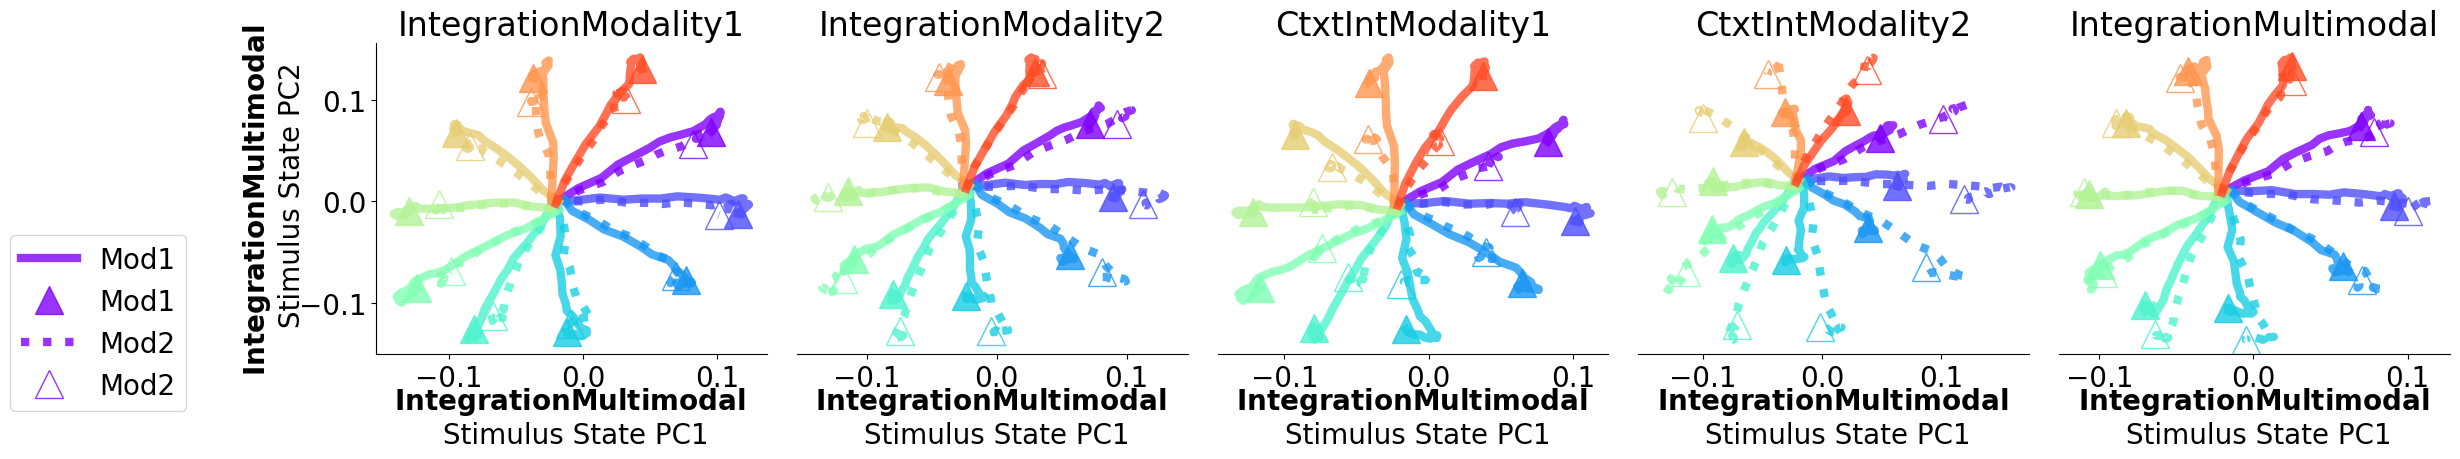

In [9]:
# model_dir_all = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))
# ckpt_n = name_best_ckpt(model_dir_all,rule)
# ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))

from tools_lnd import take_names

cmap_grad = plt.get_cmap('plasma')
script_name = 'interp_tasks_small_init_mov'

ti = 0
axs = 'pca_h'
task_set = range(6,11)
rule_master = rules_dict['all'][task_set[-1]]
epoch = 'stim1'
D = make_D_use(model_dir_all,rule_master,epoch,ti,axs)

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rule_master)

# D = make_axes(model_dir_all,rule_master,epoch,ind = -1,mod = 1)
trial_master1 = gen_trials_from_model_dir(model_dir_all,'delaydm1',noise_on = False)
trial_master2 = gen_trials_from_model_dir(model_dir_all,'delaydm2',noise_on = False)
trial_inds = range(trial_master1.epochs[epoch][0]-1,trial_master1.epochs[epoch][1])
ms = 20
lw = 6

cmap = plt.get_cmap('rainbow')
fig = plt.figure(figsize=(5*len(task_set), 5),tight_layout=True)
plt.rcParams.update({'font.size': 20})
for task_i in range(len(task_set)):
    
    task_num = task_set[task_i]
    trial1 = same_stim_trial(trial_master1,task_num)
    X1,x1 = gen_X_from_model_dir(model_dir_all,trial1)
    
    trial2 = same_stim_trial(trial_master2,task_num)
    X2,x2 = gen_X_from_model_dir(model_dir_all,trial2)

    ax = plt.subplot(1,len(task_set),task_i+1)
    for t in range(0,np.shape(x2)[1],int(np.shape(x2)[1]/10)):
        xi1 = np.dot(x1[:,t,:].T,D)
        xi2 = np.dot(x2[:,t,:].T,D)
        if t==0:
            plt.plot(xi1[trial_inds,0],xi1[trial_inds,1],c = cmap(t/np.shape(x2)[1]),label = 'Mod1',alpha = .8,linewidth = lw)
            plt.plot(xi1[trial_inds[-1],0],xi1[trial_inds[-1],1],'^',c = cmap(t/np.shape(x2)[1]),
                     markersize = ms,alpha = .8,label = 'Mod1')
            
            plt.plot(xi2[trial_inds,0],xi2[trial_inds,1],':',c = cmap(t/np.shape(x2)[1]),
                     linewidth = lw,label = 'Mod2',alpha = .8)
            plt.plot(xi2[trial_inds[-1],0],xi2[trial_inds[-1],1],'^',c = cmap(t/np.shape(x2)[1]),
                     linewidth = lw,markerfacecolor = 'none',markersize = ms,alpha = .8,label = 'Mod2')
        else:
            plt.plot(xi1[trial_inds,0],xi1[trial_inds,1],c = cmap(t/np.shape(x2)[1]),alpha = .8,linewidth = lw)
            plt.plot(xi1[trial_inds[-1],0],xi1[trial_inds[-1],1],'^',c = cmap(t/np.shape(x2)[1]),
                     linewidth = lw,markersize = ms,alpha = .8)
            
            plt.plot(xi2[trial_inds,0],xi2[trial_inds,1],':',c = cmap(t/np.shape(x2)[1]),linewidth = lw,alpha = .8)
            plt.plot(xi2[trial_inds[-1],0],xi2[trial_inds[-1],1],'^',c = cmap(t/np.shape(x2)[1]),
                     linewidth = lw,markerfacecolor = 'none',markersize = ms,alpha = .8)
#     plt.ylim((-.05,.09))    
#     plt.xlim((-.07,.07))    
    plt.title(rule_set_names[task_num])
    ax.set_xlabel(r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC1', labelpad=-5)
    if task_i==0:
        ax.set_ylabel(r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC2', labelpad=-5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if task_i > 0:
        ax.spines['left'].set_visible(False)
        plt.yticks([])
plt.subplot(1,len(task_set),1)
plt.legend(loc='center right', bbox_to_anchor=[-.45,.1])
plt.savefig(os.path.join(figpath,'visXstimCond.pdf'))
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig9/LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig9/LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig9/LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1/model.ckpt
Mo

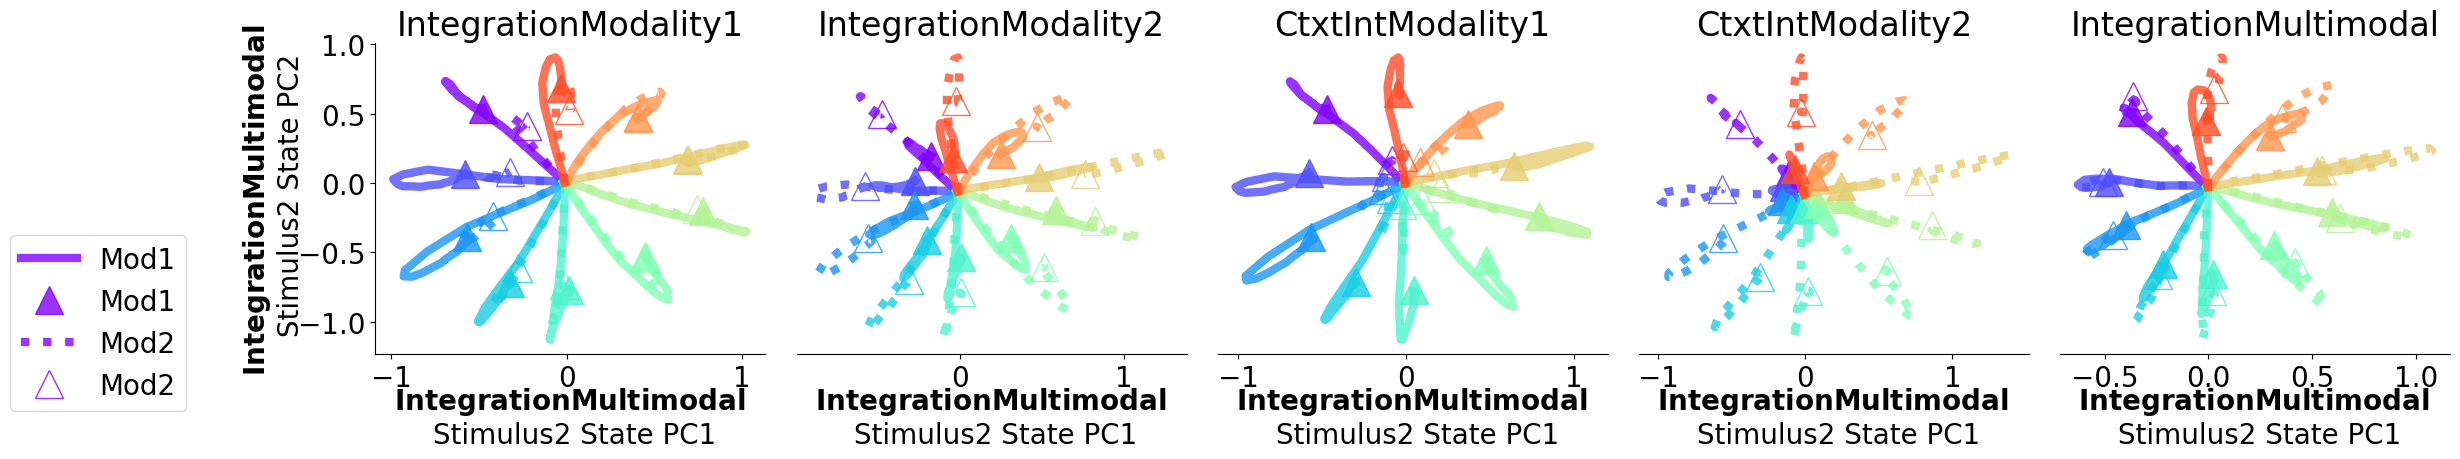

In [15]:
# model_dir_all = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))
# ckpt_n = name_best_ckpt(model_dir_all,rule)
# ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))

from tools_lnd import take_names

cmap_grad = plt.get_cmap('plasma')
script_name = 'interp_tasks_small_init_mov'

ti = 0
axs = 'pca_h'
task_set = range(6,11)
rule_master = rules_dict['all'][task_set[-1]]
epoch = 'stim2'
# D = make_D_use(model_dir_all,rule_master,epoch,ti,axs)

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rule_master)

# D = make_axes(model_dir_all,rule_master,epoch,ind = -1,mod = 1)
trial_master1 = gen_trials_from_model_dir(model_dir_all,'delaydm1',noise_on = False)
trial_master2 = gen_trials_from_model_dir(model_dir_all,'delaydm2',noise_on = False)
trial_inds = range(trial_master1.epochs[epoch][0]-1,trial_master1.epochs[epoch][1])
ms = 20
lw = 6

cmap = plt.get_cmap('rainbow')
fig = plt.figure(figsize=(5*len(task_set), 5),tight_layout=True)
plt.rcParams.update({'font.size': 20})
for task_i in range(len(task_set)):
    
    task_num = task_set[task_i]
    trial1 = same_stim_trial(trial_master1,task_num)
    X1,x1 = gen_X_from_model_dir(model_dir_all,trial1)
    
    trial2 = same_stim_trial(trial_master2,task_num)
    X2,x2 = gen_X_from_model_dir(model_dir_all,trial2)

    ax = plt.subplot(1,len(task_set),task_i+1)
    for t in range(0,np.shape(x2)[1],int(np.shape(x2)[1]/10)):
        xi1 = np.dot(x1[:,t,:].T,D)
        xi2 = np.dot(x2[:,t,:].T,D)
        if t==0:
            plt.plot(xi1[trial_inds,0],xi1[trial_inds,1],c = cmap(t/np.shape(x2)[1]),label = 'Mod1',alpha = .8,linewidth = lw)
            plt.plot(xi1[trial_inds[-1],0],xi1[trial_inds[-1],1],'^',c = cmap(t/np.shape(x2)[1]),
                     markersize = ms,alpha = .8,label = 'Mod1')
            
            plt.plot(xi2[trial_inds,0],xi2[trial_inds,1],':',c = cmap(t/np.shape(x2)[1]),
                     linewidth = lw,label = 'Mod2',alpha = .8)
            plt.plot(xi2[trial_inds[-1],0],xi2[trial_inds[-1],1],'^',c = cmap(t/np.shape(x2)[1]),
                     linewidth = lw,markerfacecolor = 'none',markersize = ms,alpha = .8,label = 'Mod2')
        else:
            plt.plot(xi1[trial_inds,0],xi1[trial_inds,1],c = cmap(t/np.shape(x2)[1]),alpha = .8,linewidth = lw)
            plt.plot(xi1[trial_inds[-1],0],xi1[trial_inds[-1],1],'^',c = cmap(t/np.shape(x2)[1]),
                     linewidth = lw,markersize = ms,alpha = .8)
            
            plt.plot(xi2[trial_inds,0],xi2[trial_inds,1],':',c = cmap(t/np.shape(x2)[1]),linewidth = lw,alpha = .8)
            plt.plot(xi2[trial_inds[-1],0],xi2[trial_inds[-1],1],'^',c = cmap(t/np.shape(x2)[1]),
                     linewidth = lw,markerfacecolor = 'none',markersize = ms,alpha = .8)
#     plt.ylim((-.05,.09))    
#     plt.xlim((-.07,.07))    
    plt.title(rule_set_names[task_num])
    ax.set_xlabel(r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC1', labelpad=-5)
    if task_i==0:
        ax.set_ylabel(r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC2', labelpad=-5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if task_i > 0:
        ax.spines['left'].set_visible(False)
        plt.yticks([])
plt.subplot(1,len(task_set),1)
plt.legend(loc='center right', bbox_to_anchor=[-.45,.1])
plt.savefig(os.path.join(figpath,'visXstimCond.pdf'))
plt.savefig(os.path.join(figpath,'visXstimCond.png'))
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig9/LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig9/LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1/model.ckpt


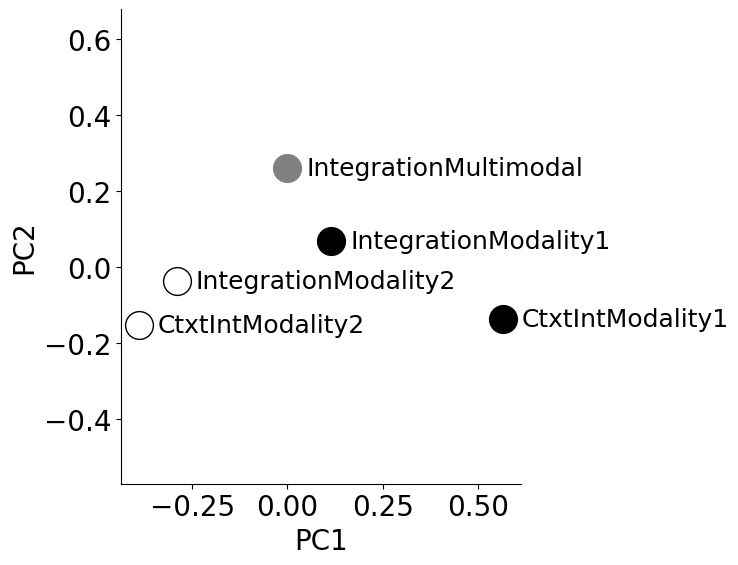

In [19]:
trial_set = (0,)#range(0,80,2)
h_context_combined = make_h_combined(model_dir_all,task_set,trial_set,epoch = 'stim1')
cl_fill = ['k','w','k','w','w']
cl_line = ['k','k','k','k','gray']
marker_fillalt_set = ['k','none','k','none','k']
ls = ['-',':','-',':','--']

X = h_context_combined
pca = PCA(n_components = 2)
h_pca_context = pca.fit_transform(X)

n_tasks = len(task_set)
fig = plt.figure(figsize=(12, 6),tight_layout=True)
ax = plt.subplot(1,2,1)
plt.rcParams.update({'font.size': 18})

for r in range(n_tasks-1):
    plt.plot(h_pca_context[r,0],h_pca_context[r,1],'o',
             markerfacecolor=cl_fill[r],markeredgecolor='k',markersize = 20)
    plt.text(h_pca_context[r,0]+.05,h_pca_context[r,1],rule_set_names[task_set[r]],rotation=0,
                             ha="left", va="center")

r = n_tasks-1
plt.plot(h_pca_context[r,0],h_pca_context[r,1],'o',
         markerfacecolor='gray',markeredgecolor='gray',markersize = 20)
plt.text(h_pca_context[r,0]+.05,h_pca_context[r,1],rule_set_names[task_set[r]],rotation=0,
                         ha="left", va="center")
# plt.axis('off')
plt.xlabel('PC1')
plt.ylabel('PC2')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axis('equal')
plt.savefig(os.path.join(figpath,'DelayDM_IC_PCs.pdf'))
plt.savefig(os.path.join(figpath,'DelayDM_IC_PCs.png'))
plt.show()

In [ ]:
trial_master1 = gen_trials_from_model_dir(model_dir_all,'contextdelaydm1',noise_on = False)
trial_master2 = gen_trials_from_model_dir(model_dir_all,'contextdelaydm2',noise_on = False)
n_trials = np.shape(trial_master1.x)[1]
trial_set = range(0,n_trials,int(n_trials/50))

#This calculates input jacobian jacobians for trials where mod1>mod2 and when mod2>mod1
task_set = range(6,11)
# time_set = (trial_master1.epochs['stim1'][0],)

################################################################################################
############ THIS FXN NO LONGER RUNS IN TF2, todo rewrite
# J_np_u_dot_delu1 = make_Jac_u_dot_delu(model_dir_all,'contextdelaydm1',task_set,trial_set)
# J_np_u_dot_delu2 = make_Jac_u_dot_delu(model_dir_all,'contextdelaydm2',task_set,trial_set)

In [ ]:
cmap=plt.get_cmap('coolwarm')
cl = [.1,.9,.2,.8,.5]
n_trials = np.shape(J_np_u_dot_delu1)[1]

fig = plt.figure(figsize=(15, 6),tight_layout=True,facecolor='white')
for t in range(len(task_set)):
    ax = plt.subplot(1,2,1)
    plt.plot(LA.norm(J_np_u_dot_delu1[t,:,0,:],axis = 1).T,ls[t],color = cl_line[t],
             label = rule_set_names[task_set[t]],linewidth = 5)
    plt.xticks(range(0,n_trials+1,int(n_trials/2)),['0',r'$\pi$',r'$2\pi$'])
    plt.xlabel('Trial #')
    plt.title('Mod1 Stimulus')
    plt.ylabel('dF/du[ctxt] dot delta u')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
#     plt.ylim((0.01,.02))

    ax = plt.subplot(1,2,2)
    plt.plot(LA.norm(J_np_u_dot_delu2[t,:,0,:],axis = 1).T,ls[t],label = rule_set_names[task_set[t]],
             color = cl_line[t],linewidth = 5)
    plt.xticks(range(0,n_trials+1,int(n_trials/2)),['0',r'$\pi$',r'$2\pi$'])
    plt.xlabel('Trial #')
    plt.title('Mod2 Stimulus')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
#     plt.ylim((0.01,.02))
    plt.yticks([])
    
plt.legend(loc='center left', bbox_to_anchor=[1.05,.5])
plt.savefig(os.path.join(figpath,'J_np_u_dot_delu1.pdf'))
plt.show()

In [ ]:
cl_fill = ['k','w','k','w','gray']
fig = plt.figure(figsize=(12, 6),tight_layout=True,facecolor='white')
ax = plt.subplot(1,2,1)
for t in [4,0,2,1,3]:
    m1 = LA.norm(J_np_u_dot_delu1[t,:,0,:],axis = 1)
    m2 = LA.norm(J_np_u_dot_delu2[t,:,0,:],axis = 1)
    plt.plot(m1,m2,'o',label = rule_set_names[task_set[t]],alpha = .8,
             markerfacecolor=cl_fill[t],markeredgecolor='k',
             markersize = 20)
    
#markerfacecoloralt=marker_fillalt_set[t],fillstyle='right',
xleft, xright = ax.get_xlim()
yleft, yright = ax.get_ylim()
left = np.min((xleft,yleft))
right = np.max((xright,yright))
plt.plot([left,right],[left,right],':k')
plt.legend(loc='center left', bbox_to_anchor=[.5,.2])
plt.ylabel('Mod2 Stimulus Response Norm')
plt.xlabel('Mod1 Stimulus Response Norm')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(os.path.join(figpath,'Comparing_EffInput.pdf'))
plt.show

In [41]:
def Jac_x(model_dir_all,rule,task_set,time_i,trial_set):

    model = Model(model_dir_all)
    with tf.Session() as sess:

        model.restore()
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        trial = generate_trials(rule, hparams, mode='test', noise_on=False, delay_fac =1)

        #get size of relevant variables to init mats
        n_inputs = np.shape(trial.x)[2]
        N = np.shape(params[0])[1]
        n_stim_dims = n_inputs - 20
        #change this depending on when in the trial you're looking [must be a transition btwn epochs]

        #init mats
        J_np_x = np.zeros((n_tasks,len(trial_set),N,N))

        for r in range(n_tasks):
            r_all_tasks_ind = task_set[r]

            trial.x[:,:,n_stim_dims:] = 0 #set all tasks to 0 #(n_time, n_trials, n_inputs)
            trial.x[:,:,n_stim_dims+r_all_tasks_ind] = 1 #except for this task

            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_trials, n_neuron)

            for trial_i in range(len(trial_set)): #depending on the analysis I was including one or many trials

                states = h_tf[time_i,trial_set[trial_i],:]
                states = states[np.newaxis,:]

                inputs = np.squeeze(trial.x[time_i,trial_set[trial_i],:]) #(n_time, n_condition, n_inputs)
                inputs = inputs[np.newaxis,:]
                
                inputs_tf = tf.constant(inputs, dtype=tf.float32)
                states_tf = tf.constant(states, dtype=tf.float32)
                output, new_states = model.cell(inputs_tf, states_tf)
                F = new_states

                J_tf_x = pfor.batch_jacobian(F, states_tf, use_pfor=False)
                J_np_x[r,trial_i,:,:] = sess.run(J_tf_x)
                
    return J_np_x

In [42]:
time_i = trial_master1.epochs['stim1'][0]-1
J_np_x1 = Jac_x(model_dir_all,'delaydm1',task_set,time_i,trial_set)
J_np_x2 = Jac_x(model_dir_all,'delaydm2',task_set,time_i,trial_set)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/mod

In [43]:
# h_context_combined = make_h_combined(model_dir_all,ckpt_n_dir,task_set,trial_set,epoch = 'stim1')
# h_context, h_stim_early, h_stim_late = make_h_combined(model_dir_all,ckpt_n_dir,task_set,(0,),n_steps_early = 0)
# h_ctxt = np.repeat(h_context_combined,n_trials,axis = 1)

del_x1 = np.squeeze(J_np_u_dot_delu1)#- h_ctxt
del_x2 = np.squeeze(J_np_u_dot_delu2)#- h_ctxt

n_tasks,n_trials,N,_ = np.shape(J_np_x1)
Jx_dot_eff_in1 = np.empty((n_tasks,n_trials,N))
Jx_dot_eff_in2 = np.empty((n_tasks,n_trials,N))

for task_i in range(n_tasks):
    for trial_i in range(n_trials):

        Jx_dot_eff_in1[task_i,trial_i,:] = np.dot(J_np_x1[task_i,trial_i,:,:],del_x1[task_i,trial_i,:].T)
        Jx_dot_eff_in2[task_i,trial_i,:] = np.dot(J_np_x2[task_i,trial_i,:,:],del_x2[task_i,trial_i,:].T)

<function matplotlib.pyplot.show>

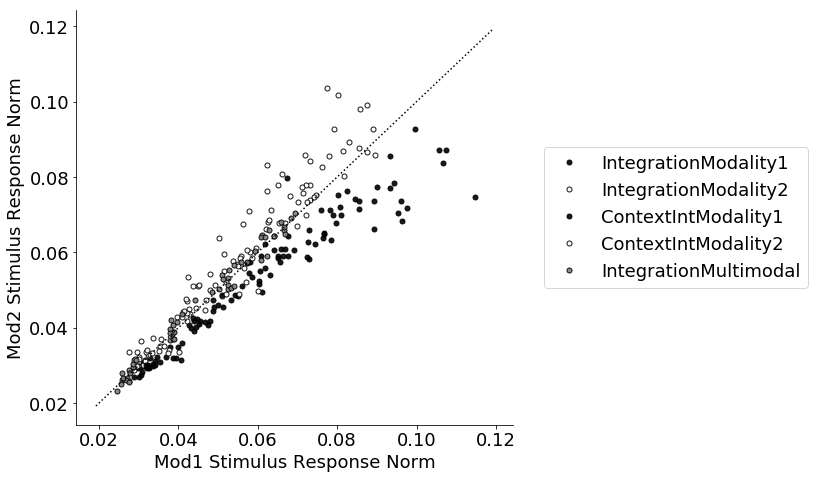

In [45]:
fig = plt.figure(figsize=(18, 7),tight_layout=True,facecolor='white')
ax = plt.subplot(1,2,1)
for t in range(len(task_set)):
    m1 = LA.norm(Jx_dot_eff_in1[t,:,:],axis = 1)
    m2 = LA.norm(Jx_dot_eff_in2[t,:,:],axis = 1)
    plt.plot(m1,m2,'o',label = rule_set_names[task_set[t]],alpha = .9,
             markerfacecolor=cl_fill[t],markeredgecolor='k',
             markersize = 5)
    

xleft, xright = ax.get_xlim()
yleft, yright = ax.get_ylim()
left = np.min((xleft,yleft))
right = np.max((xright,yright))
plt.plot([left,right],[left,right],':k')
plt.legend(loc='center left', bbox_to_anchor=[1.05,.5])
plt.ylabel('Mod2 Stimulus Response Norm')
plt.xlabel('Mod1 Stimulus Response Norm')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.title('Relaxation Dynamics')

plt.savefig(os.path.join(figpath,'Comparing_RelaxDynamics.pdf'))
plt.savefig(os.path.join(figpath,'Comparing_RelaxDynamics.png'))
plt.show